In [1]:
import numpy as np
import os
import shutil
from pImpactR import MLI as mli
from pImpactR import opt
from pImpactR.util import Me
from copy import deepcopy as copy
import time
import pickle
import matplotlib.pyplot as plt
# import psutil

In [2]:
Espread = 2.0e-3
npt = 2048*2
nturn = 512
nturnSlice = 8
hole = 0.25
CLw = 1

# Read MLI input file

In [3]:
elems0,lattices,labor = mli.readInputfile('mli.in.t3_iota_8_4_t0p4')
del(lattices[-1])

setarclen is not recognized. skipping...
autoconcat is not recognized. skipping...
autoapply is not recognized. skipping...
reftraj is not recognized. skipping...
fit is not recognized. skipping...
bip is not recognized. skipping...
tip is not recognized. skipping...


In [4]:
elems0[2]


       elem: 'globaldefaults'
       name: 'setdefaults'
 lfrngsbend: 1
 tfrngsbend: 1
  lfrngquad: 1
  tfrngquad: 1
 driftexact: 0

In [5]:
energy=elems0[0].energy*1.0e9
gam0 = energy/Me
bet0 = np.sqrt(1.0-1.0/gam0**2)

In [6]:
elems = []
for item in elems0:
    if not item.name in ['tasm','aim','vary','clear','anaprint']:
        elems.append(item)
# elems[2].driftexact = 1

In [7]:
labor = ['iotaline','mapout','fin']

# Thick sext 2 Thin multipole

In [8]:
elemList,latticeList=mli.sext2thin(elems,lattices,brho=0.50204778184582999)

In [9]:
indexThin = []
k2lList = []
for i,item in enumerate(elemList):
    if 'thlm' == item.elem:
        indexThin.append(i)
        k2lList.append(item.k2l)
nThin = len(indexThin)
print(nThin)

18


# Define parameters, getInvTBT

In [10]:
NL_nu = 0.3
NL_L  = 1.8
NL_c  = 0.01
NL_t  = 0.4
alfx = np.tan(np.pi*NL_nu)
betx = NL_L/np.sin(2.0*np.pi*NL_nu)
k = 2*alfx/betx


f3 = k/(2*bet0)
f4 = k/(2*bet0*gam0)**2
print(bet0,k,f3,f4)

0.99999423665409 1.4544633270832747 0.727235854853427 4.191323867725334e-06


In [11]:
emit = 3.3e-6
bg = gam0*bet0
sx = CLw*np.sqrt(betx*emit)
spx = CLw*np.sqrt((1+alfx*alfx)/betx*emit)
sy = CLw*np.sqrt(betx*emit)
spy = CLw*np.sqrt((1+alfx*alfx)/betx*emit)
se = CLw*Espread*bet0
print(sx,spx,se)

0.00249913697343209 0.002246493647530369 0.0019999884733081803


In [12]:
def getTBT(npt,nturn,fname='rays.out'):
    TBT = np.loadtxt(fname)
    TBT = TBT[:npt*nturn,:6]
    out = np.zeros([npt,nturn,6])
    for i in range(nturn):
        out[:,i,:] = TBT[i*npt:(i+1)*npt,:]
        out[:,i,:] = MLI2norm(out[:,i,:])
    return out,TBT[npt*(nturn-1):,:]

In [13]:
def getInv(xn,pxn,yn,pyn,delta,tau=NL_t):
    z = xn + 1j*yn
    U = np.real(z/np.sqrt(1-z**2)*np.arcsin(z))
    W = np.real(2*xn/np.sqrt(1-z**2)*np.arcsin(z))
    Hn = 0.5*(xn**2+pxn**2+yn**2+pyn**2)   +tau*U/(1.0+delta)
    In = (xn*pyn -yn*pxn)**2 +xn**2+pxn**2 +tau*W/(1.0+delta)
    return Hn,In

def getInvTBT(TBT):
    npt,nturn,dummy = TBT.shape
    InvTBT = np.zeros([npt,nturn,2])
    for iturn in range(nturn):
        data = TBT[:,iturn,:]
        for ipt in range(npt):
            xn    = data[ipt,0]
            pxn   = data[ipt,1]
            yn    = data[ipt,2]
            pyn   = data[ipt,3]
            delta = data[ipt,5]
            InvTBT[ipt,iturn,:] = getInv(xn,pxn,yn,pyn,delta)
    return InvTBT

#  Prepare particles

In [14]:
def MLI2norm(data_in,sign=1):
    data=data_in.copy()
    data[:,5] = np.sqrt(1.0-2.0*data[:,5]/bet0+data[:,5]**2)-1.0
    data[:,1] = data[:,0]*alfx/np.sqrt(betx) + data[:,1]/(1+data[:,5])*np.sqrt(betx)
    data[:,3] = data[:,2]*alfx/np.sqrt(betx) + data[:,3]/(1+data[:,5])*np.sqrt(betx)
    data[:,0] = data[:,0]/(np.sqrt(betx))
    data[:,2] = data[:,2]/(np.sqrt(betx))
    return data
    
def norm2MLI(data_in,sign=1):
    data=data_in.copy()
    data[:,1] = (-data[:,0]*alfx*sign + data[:,1])/np.sqrt(betx)*(1+data[:,5])
    data[:,3] = (-data[:,2]*alfx*sign + data[:,3])/np.sqrt(betx)*(1+data[:,5])
    data[:,0] = data[:,0]*np.sqrt(betx)
    data[:,2] = data[:,2]*np.sqrt(betx)
    data[:,5] = -np.sqrt((1.0+data[:,5])**2+1.0/(bet0*gam0)**2)+1.0/bet0
    return data

In [15]:
from scipy.stats import truncnorm

def get_truncated_normal(mean=0, sd=1.0, low=-3.0, upp=3.0, hole=0.0, n=1):
    x = np.zeros(n)
    for i in range(n):
        x[i] = 0.0
        while np.abs(x[i]) <= hole:
            f = truncnorm(
                (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)
            x[i] = f.rvs(1)
    return x

In [16]:
x=get_truncated_normal(sd=1.0,low=-CLw,upp=CLw,n=npt*5,hole=hole)
pData=np.zeros([npt,6])
pData[:,[0,1,2,3,5]]=x.reshape([npt,5])
pData[:,:4] = pData[:,:4]*np.sqrt(emit)
pData[:,5] = pData[:,5]*Espread
pDataIn = norm2MLI(pData,sign=1)
np.savetxt('./origin/rays.in',pDataIn)

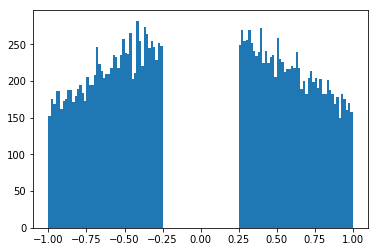

In [17]:
plt.hist(x,bins=128);

# MLI Input for arc map

In [18]:
ElemArcMap = elemList
mapout = ElemArcMap[-1]
mapout


   elem: 'ptm'
   name: 'mapout'
 matrix: 3
   poly: 3

In [19]:
LineArcMap = latticeList[0]
LineArcMap.name = 'LineArcMap'
print(LineArcMap.list[0:8])
print(LineArcMap.list[-8:])

['nlr2', 'dr077', 'ibpmb2r', 'dr078', 'qb4r', 'dr079', 'qb5r', 'dr080']
['dr015', 'qb2r', 'dr016', 'qb3r', 'dr017', 'ibpmb1r', 'dr018', 'nlr1']


In [20]:
for item in ElemArcMap:
    if item.name in ['nlr2','nlr1']:
        print(item)


 elem: 'marker'
 name: 'nlr1'

 elem: 'marker'
 name: 'nlr2'


In [21]:
LaborArcMap = labor
LaborArcMap[0]='LineArcMap'
LaborArcMap

['LineArcMap', 'mapout', 'fin']

##### test

In [22]:
mli.writeInputfile(ElemArcMap,[LineArcMap],LaborArcMap)
mli.run()
M_arc,G_arc=mli.readTransferMap()
M_arc

,1,2,3,4,5,6
1,0.999968,0.000070,0.000000,0.000000e+00,0.0,-1.147949e-06
2,-1.454445,0.999930,0.000000,0.000000e+00,0.0,-2.587771e-07
3,0.000000,0.000000,0.999995,3.984744e-07,0.0,0.000000e+00
4,0.000000,0.000000,-1.454438,1.000004e+00,0.0,0.000000e+00
5,0.000002,-0.000001,0.000000,0.000000e+00,1.0,-1.297155e+00
6,0.000000,0.000000,0.000000,0.000000e+00,0.0,1.000000e+00


# MLI Input for one-turn map

In [23]:
ElemOneturnMap = elemList[:3]
clear = mli.getElem.clear
readmap = mli.getElem.tmi(name='readmap')
savemap = mli.getElem.stm(name='savemap')
getmap  = mli.getElem.gtm(name='getmap')
getmap.iopt = 1 # concatenate
nlinsert = mli.getElem.nlinsert(steps=100)
# nlinsert = mli.getElem.drift(l=1.8)
ElemOneturnMap = ElemOneturnMap + [readmap,savemap,getmap,nlinsert,mapout,clear]
print(clear)
print(readmap)
print(savemap)
print(getmap)


 elem: 'iden'
 name: 'clear'

  elem: 'tmi'
  name: 'readmap'
  iopt: 2
 ifile: 16
  nopt: 1
 nskip: 0

 elem: 'stm'
 name: 'savemap'
 nmap: 1

 elem: 'gtm'
 name: 'getmap'
 nmap: 1
 iopt: 1


In [24]:
readmap.map2file(M_arc,G_arc)

In [25]:
LineOneturnMap = mli.getElem.line(name='LineOneturnMap',elemList = [nlinsert,'getmap'])

In [26]:
LaborOneturnMap = mli.buildLabor([readmap,savemap,clear,'LineOneturnMap','mapout','fin'])

##### test

In [27]:
mli.writeInputfile(ElemOneturnMap,[LineOneturnMap],LaborOneturnMap)
mli.run()
M_oneturn,G_oneturn=mli.readTransferMap()
M_oneturn

,1,2,3,4,5,6
1,-2.282602e-01,0.811166,0.000000,0.000000,0.0,-1.147949e-06
2,-8.365780e-01,-1.408027,0.000000,0.000000,0.0,-2.587771e-07
3,0.000000e+00,0.000000,2.963113,3.159754,0.0,0.000000e+00
4,0.000000e+00,0.000000,-1.847431,-1.632550,0.0,0.000000e+00
5,9.012806e-07,0.000002,0.000000,0.000000,1.0,-1.297135e+00
6,0.000000e+00,0.000000,0.000000,0.000000,0.0,1.000000e+00


# MLI Input for tracking

In [28]:
ElemTrack = copy(ElemOneturnMap)
raysin  =mli.getElem.raytrace(file1='rays.in',type='readonly')
dump    =mli.getElem.particledump(file='rays.out',precision=15)
track   =mli.getElem.autotrack(type='symplectic',order=5)
ElemTrack = ElemTrack + [raysin,dump,track]
LineTrack = mli.getElem.line(name='LineTrack',elemList = [nlinsert,getmap,dump])
LaborTrack = mli.buildLabor([readmap,savemap,clear,raysin,track,str(nturnSlice)+'*'+LineTrack.name,'fin'])

##### test

In [29]:
# np.savetxt('rays.in',pDataIn)

In [30]:
# readmap.map2file(M_arc,G_arc)
# mli.writeInputfile(ElemTrack,[LineTrack],LaborTrack)
# mli.run()
# TBT,pDataOut = getTBT(128,nturnSlice)
# Inv0 = getInvTBT(TBT,nturnSlice)

In [31]:
# readmap.map2file(M_oneturn,G_oneturn)
# LineTrack = mli.getElem.line(name='LineTrack',elemList = [getmap,dump.name])
# mli.writeInputfile(ElemTrack,[LineTrack],LaborTrack)
# mli.run()
# TBT,pDataOut = getTBT(128,nturnSlice)
# Inv1 = getInvTBT(TBT,nturnSlice)

In [32]:
# plt.figure(figsize=(8,3))
# plt.subplot(1,2,1)
# for i in range(128):
#     plt.plot(Inv0[i,:,0])
# plt.subplot(1,2,2)
# for i in range(128):
#     plt.plot(Inv1[i,:,0])

# Optimize

### Build objective

In [33]:
def getWeight(g):
    w = np.zeros(len(g))
    for i,item in enumerate(g['exponents']):
        nx = int(item[3])
        npx = int(item[4])
        ny = int(item[6])
        npy = int(item[7])
        nE = int(item[10])
        w[i] = np.power(sx,nx)*np.power(spx,npx)*np.power(sy,ny)*np.power(spy,npy)*np.power(se,nE)
    return w

In [34]:
G2_ref = G_arc.loc[28:76].copy()
G2_ref['GP'] = 0
G2_ref.loc[33,'GP'] = 0.5*k/bet0
G2_ref.loc[67,'GP'] = 0.5*k/bet0
W2 = getWeight(G2_ref)
# G2_ref.head()

In [35]:
G3_ref = G_arc.loc[84:200].copy()
G3_ref['GP'] = 0
G3_ref.loc[104,'GP'] = k/(2.0*bet0*gam0)**2
G3_ref.loc[184,'GP'] = k/(2.0*bet0*gam0)**2
W3 = getWeight(G3_ref)

In [36]:
G4_ref = G_arc.loc[210:450].copy()
G4_ref['GP'] = 0
W4 = getWeight(G4_ref)

In [37]:
G5_ref = G_arc.loc[462:910].copy()
G5_ref['GP'] = 0
W5 = getWeight(G5_ref)

In [38]:
def getINVobj(INV,INV0):
    nturn = len(INV[0,:,0])
    obj=0.0
    tmpHmax = 0.0
    tmpImax = 0.0
    for i in range(nturn):
        tmpH = (INV[:,i,0]/INV0[:,0]-1.0)**2 
        tmpI = (INV[:,i,1]/INV0[:,1]-1.0)**2
        tmpHmax = tmpH.max()
        tmpImax = tmpI.max()
        tmp = (36.0*np.sum(tmpH)/npt + 9.0*np.sum(tmpI)/npt + 4.0*tmpHmax + tmpImax)/50.0
        obj = obj + tmp
        if tmp > 1.0:
            return obj/(i+1)
    return obj/nturn

In [39]:
# pData=np.zeros([npt,6])
# x = np.random.random([npt,4])
# c0 = np.cos(x[:,0])
# s0 = np.sin(x[:,0])
# c1 = np.cos(x[:,1])
# s1 = np.sin(x[:,1])
# c2 = np.cos(x[:,2])
# s2 = np.sin(x[:,2])
# pData[:,0] = Rsphere*c0
# pData[:,1] = Rsphere*s0*c1
# pData[:,2] = Rsphere*s0*s1*c2
# pData[:,3] = Rsphere*s0*s1*s2
# pData[:,5] = (x[:,3]-0.5)*2*Espread
# pDataIn = norm2MLI(pData,sign=1)

In [40]:
#%%
def objFunc(arg): 
    target = opt.id_generator()  # generage random directory name
    while os.path.exists(target):  
        target = opt.id_generator()
    shutil.copytree('origin', target)
    os.chdir(target) # cd to the randome directory and
    
    for i,j in enumerate(indexThin):
        elemList[j]['k2l']=arg[i]
    

    # 1st Objective : ArcMap
    mli.writeInputfile(ElemArcMap,[LineArcMap],LaborArcMap)
    mli.run()
    M,G = mli.readTransferMap()
    
    test = np.all(G2_ref['exponents'].values == G.loc[28 :76 ]['exponents'].values) and \
           np.all(G3_ref['exponents'].values == G.loc[84 :200]['exponents'].values) and \
           np.all(G4_ref['exponents'].values == G.loc[210:450]['exponents'].values) and \
           np.all(G5_ref['exponents'].values == G.loc[462:910]['exponents'].values)
    
    if not test:
        raise ValueError("PROBLEM!!!")
        
    obj = np.sum(((G.loc[28 :76 ,'GP'].values-G2_ref['GP'].values)*W2)**2) + \
          np.sum(((G.loc[84 :200,'GP'].values-G3_ref['GP'].values)*W3)**2) + \
          np.sum( (G.loc[210:450,'GP'].values*W4)**2) + \
          np.sum( (G.loc[462:910,'GP'].values*W5)**2)
    obj = obj*1.0e11
    obj = obj**0.2
    if obj > 1.0:
        os.chdir('..')
        shutil.rmtree(target)
        return obj
    
    # 2nd Objective : TBTInv
          
    readmap.map2file(M,G)
    mli.writeInputfile(ElemTrack,[LineTrack],LaborTrack)
    mli.run(4)       
    TBT,pDataOut = getTBT(npt,nturnSlice)
    !rm rays.out
    if(np.isnan(TBT.max())):
        os.chdir('..')
        shutil.rmtree(target)
        return 1.0
    Inv  = getInvTBT(TBT)
    Inv0 = Inv[:,0,:]
    obj2 = getINVobj(Inv,Inv0)
    
    if obj2 > 1.0:
        os.chdir('..')
        shutil.rmtree(target)
        return obj*obj2
    
    obj2tot = obj2
    for i in range(int(nturn/nturnSlice)-1):
        np.savetxt('rays.in',pDataOut)
        mli.run(4)
#         if i<48:
#             mli.run(8)
#         else:
#             mli.run(12)
#             nP = 0
#             for p in psutil.process_iter():
#                 if p.name()[:5] == 'mli.x':
#                     nP=nP+1
#             if nP>48:
#                 mli.run()
#             elif nP>32:
#                 mli.run(2)
#             elif np>24:
#                 mli.run(4)
#             elif np>16:
#                 mli.run(8)
#             elif np>8:
#                 mli.run(16)
#             else:
#                 mli.run(32)
        TBT,pDataOut = getTBT(npt,nturnSlice)
        !rm rays.out
        if(np.isnan(TBT.max())):
            os.chdir('..')
            shutil.rmtree(target)
            return obj*obj2
        
        Inv  = getInvTBT(TBT)
        Inv0 = Inv[:,0,:]
        obj2_tmp = getINVobj(Inv,Inv0)
        obj2tot = obj2tot+obj2_tmp
        obj2 = (obj2tot/(i+1))*(0.8**(i+1))
        
        if obj2_tmp > 1.0:
            os.chdir('..')
            shutil.rmtree(target)
            return obj*obj2
    os.chdir('..')
    shutil.rmtree(target)
    return obj*obj2

In [41]:
with open('result.thin.3sig.sext','rb') as fp:
    result=pickle.load(fp)

In [42]:
objFunc(result.x)

1.7506796779656966e-08

In [43]:
objFunc([0]*nThin)

5.656231778003757e-09

In [44]:
# #%% run optim
bounds = [(-100,100)]*nThin
# result=opt.differential_evolution(objFunc, bounds, ncore=32, popsize=32*8,
#                                   disp=True, polish=True, maxtime=60*10) 
# #                                     stop running at maximum 10 min

In [45]:
# with open('result.Inv.thin.'+str(CLw)+'sig.sext','wb') as fp:
#     pickle.dump(result,fp)

In [46]:
with open('result.Inv.thin.'+str(CLw)+'sig.sext','rb') as fp:
    result=pickle.load(fp)

In [47]:
result.message

'Maximum time has been exceeded.'

In [48]:
np.sort(result.population_energies)[:16]

array([2.51073825e-09, 2.51073825e-09, 2.71223793e-09, 2.74090967e-09,
       2.83597995e-09, 2.84213391e-09, 2.86766521e-09, 2.89566598e-09,
       2.90063196e-09, 2.92371194e-09, 2.92700597e-09, 2.95987065e-09,
       2.98637699e-09, 3.00393231e-09, 3.01254651e-09, 3.01308829e-09])

In [49]:
np.sort(result.population_energies)[-16:]

array([4.24138992e-09, 4.25505048e-09, 4.25618218e-09, 4.28891308e-09,
       4.30206815e-09, 4.32240274e-09, 4.32515413e-09, 4.33371871e-09,
       4.34115773e-09, 4.35500058e-09, 4.35774785e-09, 4.37049024e-09,
       4.40399161e-09, 4.44552668e-09, 4.60566416e-09, 4.71368942e-09])

In [ ]:
while True:
    previous_result = result
    if hasattr(result,'x'): 
        break
    result = opt.differential_evolution(objFunc, bounds, ncore=4, 
                                           prev_result=previous_result, 
                                           disp=True, maxtime=60*10)
    with open('result.Inv.thin.'+str(CLw)+'sig.sext','wb') as fp:
        pickle.dump(result,fp)

differential_evolution step 0: f(x)= 2.51074e-09


In [ ]:
result